# Cats vs Dogs -- with help from a pre-trained image classification model!

<img src="https://raw.githubusercontent.com/benjum/UCLAX-24W-ML/main/Data/cat-dog-data/test/cat/cat.1500.jpg" width="250px"/> <img src="https://raw.githubusercontent.com/benjum/UCLAX-24W-ML/main/Data/cat-dog-data/test/dog/dog.1500.jpg" width="250px"/>

#### We're going to use TensorFlow and Convolutional Neural Networks to identify whether a picture is a dog or a cat.

Side-note:  I think the dataset is biased against cats, because most of the cats I've looked at in this dataset look crazy, a bit ugly, or like they totally have it out for the dogs!

This dataset is a subset of the data that can be obtained at [Kaggle's Dogs Vs Cats page](https://www.kaggle.com/c/dogs-vs-cats/data).

The code below was motivated by Chollet's Deep Learning with Python book, in which you will find many, many more interesting details and tidbits about doing deep learning.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

Special note:  The below can take a long time to run if you only run it using your computer's CPU.  It is highly recommended that you get TensorFlow running on your GPUs if you want to reproduce the cell execution below.  I (B. Winjum) ran this on my Mac M1 and am doing this with TensorFlow 2.13 (along with tensorflow-metal) so that I can run on a GPU.  If you need help running this notebook and/or getting tensorflow running on your local GPU, please reach out for assistance as needed.

In [2]:
tf.__version__

'2.13.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# tf.get_logger().setLevel('ERROR')

## Getting our data

Our data images are in folders that are already split up into training, test, and validation sets.  Furthermore, they are aleady split up into cat and dog folders.

The following image_dataset_from_directory gets class labels based on whether the images are retrieved from these "cat" or "dog" folders.

In [5]:
import os

In [6]:
os.path.join(os.getcwd(), "..", "..", "Data", "cat-dog-data", "train")

'/Users/bwinjum/git/UCLAX-24W-ML/Notebooks/Week09/../../Data/cat-dog-data/train'

In [7]:
train_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "..", "..", "Data", "cat-dog-data", "train"),
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "..", "..", "Data", "cat-dog-data", "validation"),
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    os.path.join(os.getcwd(), "..", "..", "Data", "cat-dog-data", "test"),
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
train_ds = train_dataset.unbatch()
a = list(train_ds)

In [9]:
len(a)

2000

In [10]:
a[2][0].shape

TensorShape([180, 180, 3])

In [11]:
a[2][1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [12]:
a[2][0][0][2]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([78.54445 , 94.433334, 87.977776], dtype=float32)>

In [13]:
a[2][1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

The label for image 2 is 1
The picture for image 2 is


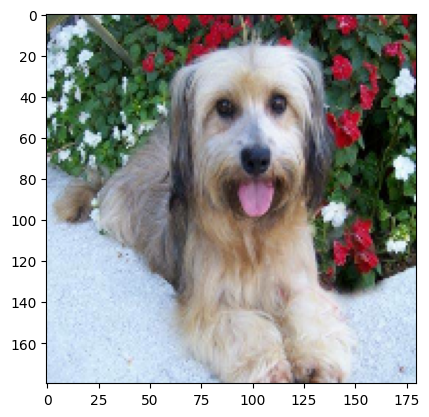

In [14]:
b = 2
print("The label for image",b,"is",a[b][1].numpy())
print("The picture for image",b,"is")
plt.imshow(a[b][0].numpy().astype('int32'));

# Using pre-trained model

We will try using a pre-trained model available through Keras Applications.  "Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning."
* https://keras.io/api/applications/

## Feature extraction without data augmentation

In [15]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [16]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [17]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 11ms/step


In [18]:
train_features.shape

(2000, 5, 5, 512)

In [19]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=True)
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 16ms/step - loss: 20.1102 - accuracy: 0.9225 - val_loss: 3.1253 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 1s 12ms/step - loss: 4.0664 - accuracy: 0.9710 - val_loss: 2.6107 - val_accuracy: 0.9820
Epoch 3/20
63/63 [==============================] - 1s 12ms/step - loss: 1.7941 - accuracy: 0.9830 - val_loss: 12.3155 - val_accuracy: 0.9470
Epoch 4/20
63/63 [==============================] - 1s 11ms/step - loss: 1.8174 - accuracy: 0.9875 - val_loss: 3.2555 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 1s 12ms/step - loss: 1.1469 - accuracy: 0.9900 - val_loss: 6.7275 - val_accuracy: 0.9710
Epoch 6/20
63/63 [==============================] - 1s 12ms/step - loss: 0.9927 - accuracy: 0.9925 - val_loss: 7.5738 - val_accuracy: 0.9680
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 0.9434 - accuracy: 0.9925 - val_loss: 3.5798 - val_accuracy: 0.9800
Epoch 8/20


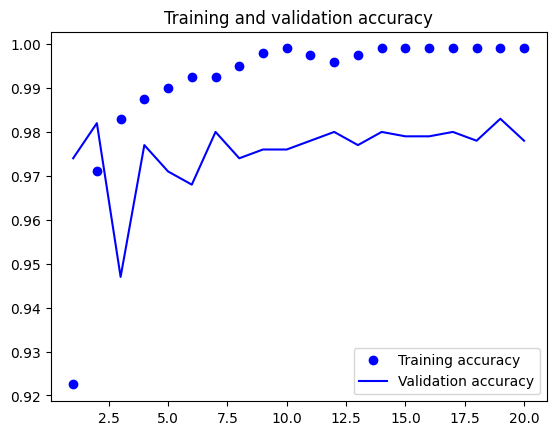

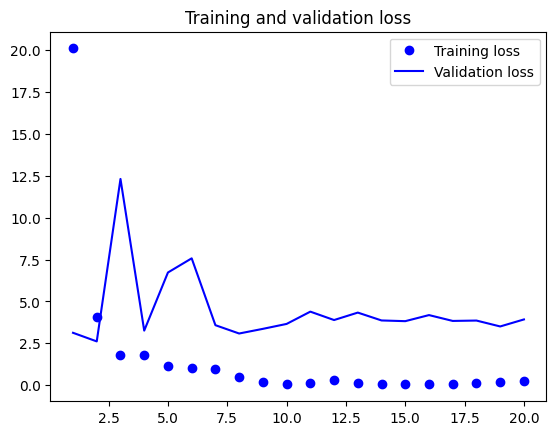

In [20]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.load_weights("feature_extraction.keras")

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 5ms/step - loss: 3.1405 - accuracy: 0.9740


In [25]:
test_acc

0.9739999771118164

## Feature extraction with data augmentation

In [26]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [27]:
conv_base.trainable = True
len(conv_base.trainable_weights)

26

In [28]:
conv_base.trainable = False
len(conv_base.trainable_weights)

0

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=True
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 225ms/step - loss: 17.8820 - accuracy: 0.8985 - val_loss: 4.1875 - val_accuracy: 0.9680
Epoch 2/50
63/63 [==============================] - 14s 219ms/step - loss: 6.4932 - accuracy: 0.9520 - val_loss: 7.2797 - val_accuracy: 0.9660
Epoch 3/50
63/63 [==============================] - 14s 221ms/step - loss: 8.5465 - accuracy: 0.9475 - val_loss: 2.9062 - val_accuracy: 0.9740
Epoch 4/50
63/63 [==============================] - 14s 220ms/step - loss: 3.7602 - accuracy: 0.9635 - val_loss: 3.4970 - val_accuracy: 0.9750
Epoch 5/50
63/63 [==============================] - 14s 220ms/step - loss: 4.1209 - accuracy: 0.9600 - val_loss: 1.8624 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 14s 219ms/step - loss: 3.0116 - accuracy: 0.9645 - val_loss: 4.1880 - val_accuracy: 0.9720
Epoch 7/50
63/63 [==============================] - 14s 220ms/step - loss: 2.3967 - accuracy: 0.9735 - val_loss: 2.8284 - val_accuracy: 0.971

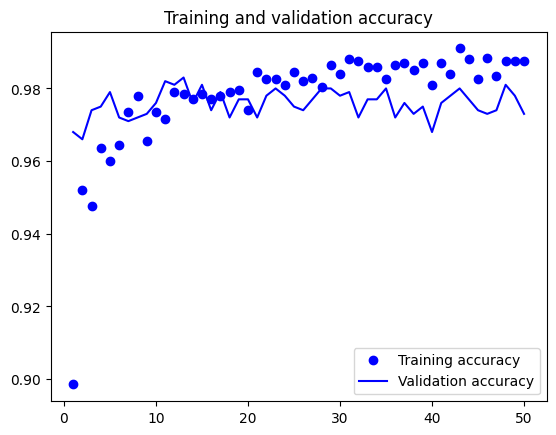

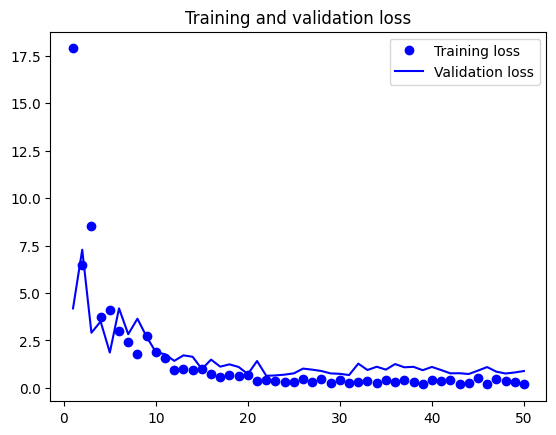

In [30]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
# this loads the best weights into the model
model.load_weights("feature_extraction_with_data_augmentation.keras")

In [32]:
test_loss, test_acc = model.evaluate(test_dataset)

63/63 [==============================] - 8s 130ms/step - loss: 0.9507 - accuracy: 0.9755


In [33]:
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.975


In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [35]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [36]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [38]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=True
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 17s 258ms/step - loss: 0.3629 - accuracy: 0.9800 - val_loss: 0.6009 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 16s 249ms/step - loss: 0.1950 - accuracy: 0.9840 - val_loss: 1.0945 - val_accuracy: 0.9750
Epoch 3/30
63/63 [==============================] - 16s 252ms/step - loss: 0.2112 - accuracy: 0.9865 - val_loss: 0.5456 - val_accuracy: 0.9770
Epoch 4/30
63/63 [==============================] - 16s 249ms/step - loss: 0.2533 - accuracy: 0.9840 - val_loss: 0.5584 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 16s 250ms/step - loss: 0.1771 - accuracy: 0.9885 - val_loss: 0.6567 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 16s 250ms/step - loss: 0.1582 - accuracy: 0.9895 - val_loss: 0.5682 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 16s 250ms/step - loss: 0.0990 - accuracy: 0.9905 - val_loss: 0.4800 - val_accuracy: 0.9820

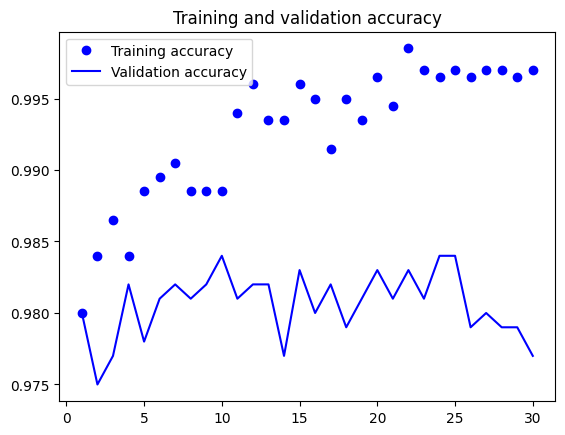

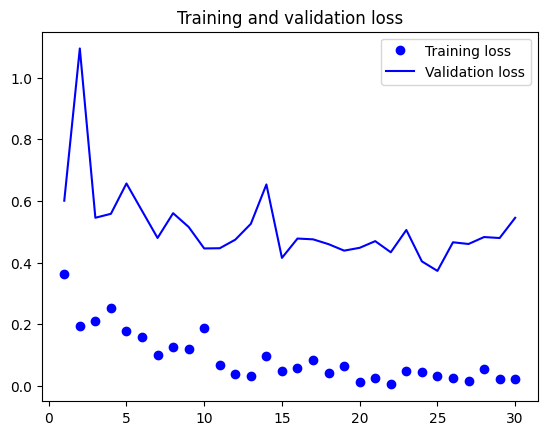

In [39]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [40]:
model.load_weights("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 129ms/step - loss: 0.5365 - accuracy: 0.9815
Test accuracy: 0.982
